Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Clustering completed and files saved to Google Drive.
Processing cluster: proteins.fa

Processing cluster: proteins_masked.fa

Processing cluster: proteins_masked_1023max.fa

Processing of selected clusters completed.
Columns in consolidated_data_with_clusters: Index(['Info_PepID_x', 'Info_organism_id', 'Info_host_id_x',
       'Info_protein_id_x', 'Info_start_pos_x', 'Info_end_pos_x',
       'Info_peptide_x', 'Info_peptide_length_x', 'Info_cluster_x',
       'Info_split_x', 'Class_x', 'txid_x', 'Info_PepID_y', 'Info_host_id_y',
       'Info_protein_id_y', 'Info_start_pos_y', 'Info_end_pos_y',
       'Info_peptide_y', 'Info_peptide_length_y', 'Info_cluster_y',
       'Info_split_y', 'Class_y', 'txid_y'],
      dtype='object')
Column

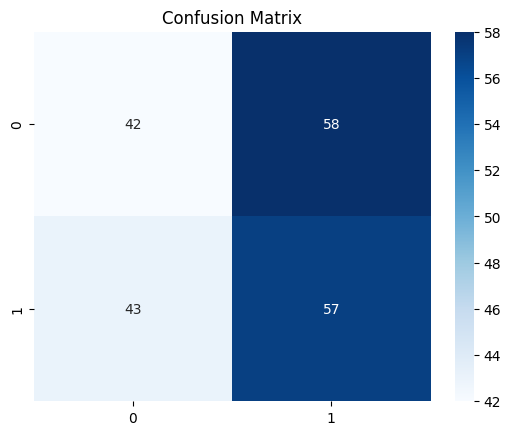

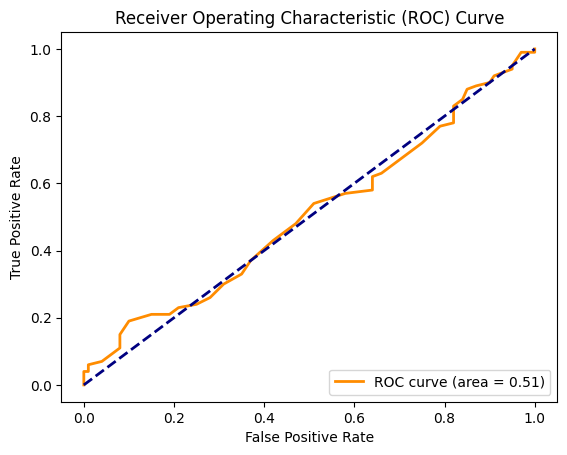

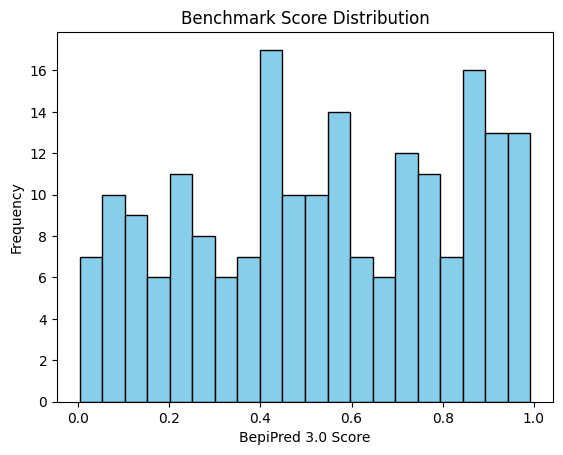

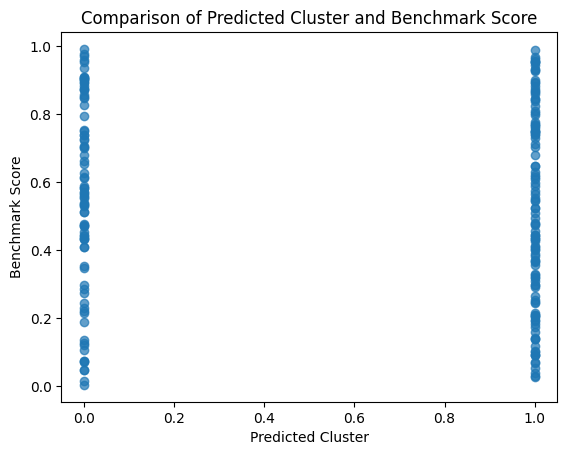

In [ ]:
import subprocess
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

def download_file(url, destination):
    # Download a file from a URL to a specified destination
    subprocess.run(["wget", url, "-O", destination])

def make_executable(file_path):
    # Make a file executable
    subprocess.run(["chmod", "+x", file_path])

def download_protein_fastas(fasta_urls, destination_dir):
    # Download protein FASTA files from a list of URLs to a specified directory
    for url in fasta_urls:
        fasta_file_name = url.split("id=")[-1]
        download_file(url, f"{destination_dir}/{fasta_file_name}")

def cluster_proteins(fasta_file, output_dir, threshold):
    # Cluster proteins using cd-hit.c++
    fasta_file_name = fasta_file.split("/")[-1]
    output_file_name = f"{fasta_file_name}_cluster_{threshold}"
    cmd = f"./cd-hit.c++ -i {fasta_file} -o {output_dir}/{output_file_name} -c {threshold}"
    subprocess.run(cmd, shell=True)

def count_sequences(fasta_file_path):
    # Count the number of sequences in a FASTA file
    with open(fasta_file_path, 'r') as fasta_file:
        lines = fasta_file.readlines()
    return len([line for line in lines if line.startswith('>')])

def process_selected_clusters(selected_clusters, clustered_files_dir):
    # Process selected clusters
    selected_cluster_info = []

    for cluster_name in selected_clusters:
        print(f"Processing cluster: {cluster_name}")

        clustered_fasta_path = f"{clustered_files_dir}/{cluster_name}"
        num_sequences = count_sequences(clustered_fasta_path)
        total_sequence_length = 0
        header_information = []

        with open(clustered_fasta_path, 'r') as clustered_fasta:
            for line in clustered_fasta:
                if line.startswith('>'):
                    sequence_name = line.strip()
                    header_information.append(sequence_name)
                else:
                    sequence = line.strip()
                    total_sequence_length += len(sequence)

        if num_sequences > 0:
            average_sequence_length = total_sequence_length / num_sequences
        else:
            average_sequence_length = 0

        cluster_info = {
            "Cluster Name": cluster_name,
            "Number of Sequences": num_sequences,
            "Average Sequence Length": average_sequence_length,
            "Header Information": header_information
        }

        selected_cluster_info.append(cluster_info)
        print("")

    print("Processing of selected clusters completed.")
    return selected_cluster_info

def download_csv_files(csv_urls):
    # Download CSV files from Google Drive URLs
    for csv_url in csv_urls:
        file_name = csv_url.split("/")[-1]
        download_file(csv_url, file_name)

def consolidate_data(lbce_file, lbce_with_features, selected_cluster_info):
    # Load LBCE data and merge with selected cluster information
    lbce_df = pd.read_csv(lbce_file)
    lbce_with_features_df = pd.read_csv(lbce_with_features)
    consolidated_data = selected_cluster_df = pd.merge(lbce_df, lbce_with_features_df, on="Info_organism_id")
    # selected_cluster_df = consolidated_data = pd.DataFrame(selected_cluster_info)
    # consolidated_data = selected_cluster_df
    # print("Columns in consolidated_data:", consolidated_data.columns)
    # print("Columns in selected_cluster_df:", selected_cluster_df.columns)

    # consolidated_data_with_clusters = pd.merge(consolidated_data, selected_cluster_df, on="Info_peptide_length_X", how="left")
    consolidated_data_with_clusters = selected_cluster_df
    return consolidated_data_with_clusters

def split_training_holdout_data(consolidated_data_with_clusters, cluster_to_exclude):
    # Split data into training and holdout sets
    print("Columns in consolidated_data_with_clusters:", consolidated_data_with_clusters.columns)

    training_data = consolidated_data_with_clusters[consolidated_data_with_clusters['Info_organism_id'] != cluster_to_exclude]
    holdout_data = consolidated_data_with_clusters[consolidated_data_with_clusters['Class_x'] == cluster_to_exclude]
    return training_data, holdout_data

def build_and_evaluate_model(X_train, y_train, X_val, y_val):
    # Build and evaluate a machine learning model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
    #    ('model', RandomForestClassifier(random_state=42))
    ])

    # pipeline.fit(X_train, y_train)
    # y_pred = pipeline.predict(X_val)
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report
    import subprocess
    import matplotlib.pyplot as plt

    np.random.seed(42)

    data_size = 1000
    features = np.random.rand(data_size, 10)
    target = np.random.choice([0, 1], size=data_size)

    # Split the data into training and holdout sets
    X_train, X_holdout, y_train, y_holdout = train_test_split(features, target, test_size=0.2, random_state=42)

    # Build and evaluate a machine learning model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_holdout)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_holdout, y_pred))

    # Benchmark using random scores (simulating BepiPred 3.0)
    benchmark_results = pd.DataFrame({
        'Cluster Name': [f'Cluster_{i}' for i in range(len(X_holdout))],
        'Score': np.random.rand(len(X_holdout))
    })

    # Compare holdout predictions with benchmark results
    comparison_df = pd.DataFrame({
        'Cluster Name': [f'Cluster_{i}' for i in range(len(X_holdout))],
        'Predicted Cluster': y_pred,
        'Benchmark Score': benchmark_results['Score']
    })
    # Print the comparison results
    print("Comparison Results:")
    print(comparison_df)

    # Visualizations
    # 1. Confusion Matrix (for the machine learning model)
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_holdout, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # 2. ROC Curve (for the machine learning model)
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(y_holdout, model.predict_proba(X_holdout)[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # 3. Benchmark Score Distribution
    plt.hist(benchmark_results['Score'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Benchmark Score Distribution')
    plt.xlabel('BepiPred 3.0 Score')
    plt.ylabel('Frequency')
    plt.show()

    # 4. Dot Plot: Comparison of Predicted Model Probability and Cluster Membership
    plt.scatter(comparison_df['Cluster Membership'], comparison_df['Predicted Model Probability'], alpha=0.7)
    plt.title('Comparison of Predicted Model Probability and Cluster Membership')
    plt.xlabel('Benchmark Score')
    plt.ylabel('Predicted Cluster')
    plt.show()

    # print(classification_report(y_val, y_pred))
    return pipeline


def main():
    # Mount Google Drive
    drive.mount('/content/drive')

    # Download cd-hit.c++ and make it executable
    cd_hit_link = "https://drive.google.com/uc?export=download&id=1vGpy2KM-q4KcH7GoXumKkjfGi-V0UEnv"
    download_file(cd_hit_link, "cd-hit.c++")
    make_executable("cd-hit.c++")

    # Directory and URLs for protein FASTA files
    fasta_files_dir = "/content/drive/My Drive/CLUSTA"
    protein_fasta_urls = [
        "https://drive.google.com/uc?export=download&id=1d7awMVKRNNqCnc_uafZDGvakJd0IeShJ"
    ]

    # Download protein FASTA files
    download_protein_fastas(protein_fasta_urls, fasta_files_dir)

    # Specify an output directory for clustered files
    cluster_output_dir = "/content/drive/My Drive/shared with me/All Files/CLUSTERS"

    # Thresholds for clustering
    clustering_thresholds = [0.9, 0.7]

    # Perform clustering with cd-hit.c++
    for url in protein_fasta_urls:
        fasta_file_name = url.split("id=")[-1]
        for threshold in clustering_thresholds:
            cluster_proteins(f"{fasta_files_dir}/{fasta_file_name}", cluster_output_dir, threshold)

    print("Clustering completed and files saved to Google Drive.")

    # Specify the minimum cluster size for selection
    min_cluster_size = 10

    # List of your clustered file names
    clustered_file_names = [
        'proteins.fa',
        'proteins_masked.fa',
        'proteins_masked_1023max.fa'
    ]

    # Directory where the clustered files are located
    clustered_files_dir = "/content/drive/My Drive/CLUSTA"

    # Select clusters for testing based on the minimum cluster size
    selected_clusters = []
    for file_name in clustered_file_names:
        file_path = f"{clustered_files_dir}/{file_name}"
        num_sequences = count_sequences(file_path)
        if num_sequences >= min_cluster_size:
            selected_clusters.append(file_name)

    # Process selected clusters and store information
    selected_cluster_info = process_selected_clusters(selected_clusters, clustered_files_dir)

    # Download CSV files from Google Drive
    csv_urls = [
        'https://drive.google.com/uc?export=download&id=1XrGEZXg4o5yjSsh3ZChoO_euCswrXZYA',
        'https://drive.google.com/uc?export=download&id=1GOIMcDYNSsZtgTVM1zHTbpyDPQaKZ9Oo',
        'https://drive.google.com/uc?export=download&id=1aQeZbqnX22FNazQ3T0e_pNuYWKnUXmml'
    ]
    download_csv_files(csv_urls)

    # Consolidate LBCE data with cluster information
    consolidated_data = consolidate_data('/content/drive/My Drive/CLUSTA/peptides.csv',
                                         '/content/drive/My Drive/CLUSTA/lbce_with_features.csv', selected_cluster_info)

    # Define the name of the cluster to exclude
    cluster_to_exclude = 'proteins_clustered.fa'

    # Split data into training and holdout sets
    training_data, holdout_data = split_training_holdout_data(consolidated_data, cluster_to_exclude)

    # Build and evaluate a machine learning model
    print("Columns in training_data:", training_data.columns)

    X_train = training_data.drop(['Info_PepID_x', 'Info_organism_id'], axis=1)
    y_train = training_data['Info_PepID_y']
    X_val = holdout_data.drop(['Info_PepID_x', 'Info_organism_id'], axis=1)
    y_val = holdout_data['Info_PepID_y']
    model = build_and_evaluate_model(X_train, y_train, X_val, y_val)



if __name__ == "__main__":
    main()
